# Classifier calibration
## The why, when and how of model calibration for classification tasks.

When dealing with a classification problem, collecting only the predictions on a test set is hardly enough; more often than not we would like to compliment them with some level of confidence. To that end, we make use of the associated probability, meaning the likelihood calculated by the classifier, which specifies the class for each sample. But does this always reflect reality? And if not, how can we tell?

# Introduction
Imagine we have two binary classifiers; model A and model B. Model A is 85% accurate and 0.86 confident for each prediction it makes. On the other hand, model B is also 85% accurate but 0.99 confident for each of its predictions. Which model do you think is better?

In this story, I will try to convince you that model A is better. Model A considers itself precise 86% of the time and indeed, that's almost the case. To the contrary, model B is overconfident about its predictions. This toy example demonstrates the intuition behind probability and model calibration.

Model calibration refers to the process where we take a model that is already trained and apply a post-processing operation, which improves its probability estimation. Thus, if we were to inspect the samples that were estimated to be positive with a probability of 0.85, we would expect that 85% of them are in fact positive.

Formally, a model is perfectly calibrated if, for any probability value p, a prediction of a class with confidence p is correct 100*p per cent of the time.

Now, because an image is worth a thousand words if you try to visualize it and plot every value of p, in the interval from 0 to 1, we would expect to get a perfect linear relationship between the computed probability and the fraction of positives.
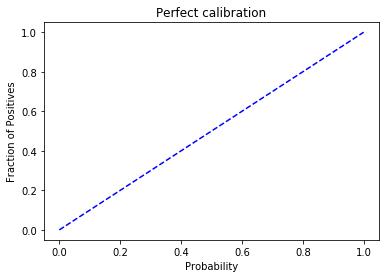

A perfectly calibrated classifier

In the following sections, we see the why, when and how to calibrate your classifiers.

# Why is model calibration important?
Model calibration is important only if you care about the probabilities your model computes. For instance, let us say that you are building a recommender engine, that ranks products according to user preferences. If your model estimates that user u will buy product a with probability 0.9, and item b with probability 0.7, you can go ahead and serve product a first. No need to calibrate that model.

However, `if you are building a mission-critical application, which computes the probability of a person being sick, the actual probability value is significant. If, for example, your model is not that confident for a specific patient, a human doctor should certainly know about it and act accordingly.`

There are also other cases where model calibration is useful:
+ Debugging: we want to know when our model is wrong with high confidence or assigns a low probability to the correct class
+ Ensembles: if we want to combine many probability models, having accurate predictions makes a difference

# How to check your model
So far we have seen what is model calibration and why it is important in some cases. But how can we check if our classifier is calibrated?

The best way is to see it with our own eyes. For this experiment, we create a random dataset for classification, using the `make_classification` helper method that scikit-learn provides.


In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split


# create a random, binary classification problem, with 100000 samoles and 20 features
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=7, n_redundant=10,
                                    random_state=42)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.99, random_state=42)

Next, we instantiate two classifiers to compare; a simple logistic regression model and an implementation of Support Vector Machines provided by scikit-learn.

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


lgr = LogisticRegression(C=1, solver='lbfgs')
svc = SVC(max_iter=10000, probability=True)

Finally, we fit the classifiers to our training data and compute our predictions on the test data set. Specifically for the SVM, to get the probabilities for the positive class we need to know how the decision function separates the test samples, and normalize the results to be between `0` and `1`.


In [ ]:
lgr.fit(X_train, y_train).predict_proba(X_test)[:,1]

array([0.05864369, 0.68836009, 0.26473652, ..., 0.9631537 , 0.22492048,
       0.48676644])

In [ ]:
svc.fit(X_train, y_train).predict(X_test)

array([0, 1, 0, ..., 1, 0, 0])

In [ ]:
svc.decision_function(X_test)

array([-1.02804593,  0.24443687, -1.66403   , ...,  1.87596623,
       -1.96166229, -0.63640474])

In [ ]:
probs_lgr = lgr.fit(X_train, y_train).predict_proba(X_test)[:,1]

preds_svc = svc.fit(X_train, y_train).predict(X_test)
probs_svc = svc.decision_function(X_test)#The desion function tells us on which side of the hyperplane generated by the classifier we are (and how far we are away from it). 
probs_svc = (probs_svc - probs_svc.min()) / (probs_svc.max() - probs_svc.min())

In [ ]:
probs_svc

array([0.30106337, 0.51410067, 0.19458781, ..., 0.78724905, 0.14475862,
       0.3666314 ])

Let us now plot the `Kernel Density Estimation` for the two classifiers.

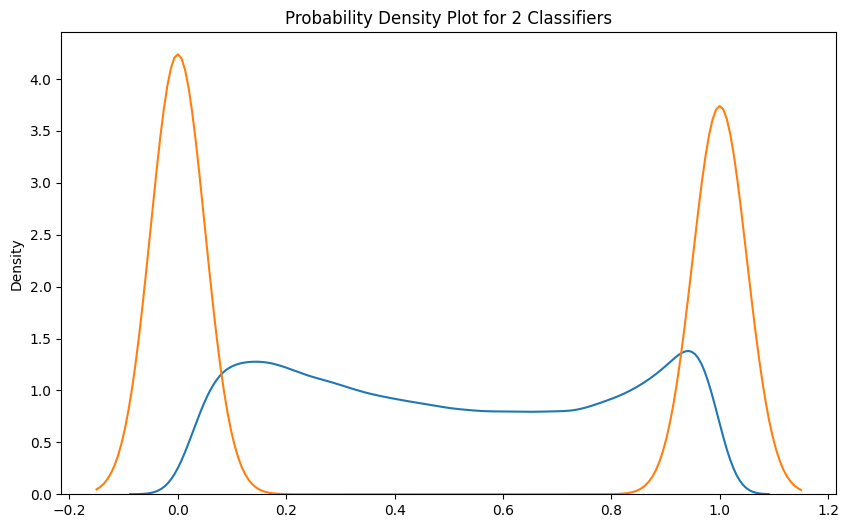

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.kdeplot(probs_lgr, label='Logistic regression')
sns.kdeplot(preds_svc, label='SVM')
plt.title("Probability Density Plot for 2 Classifiers")
plt.show()

As we expected, the results we get from logistic regression is spread from 0 to 1, while the SVM predictions are exactly 0 or 1. Following, let us check the AUC-ROC curve for the two binary classifiers, but this time using the probabilities we calculated for the SVM.

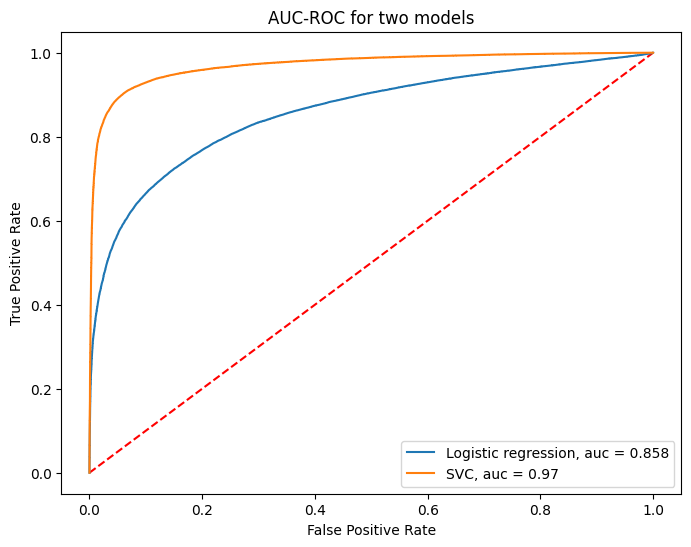

In [ ]:
from sklearn import metrics


plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1],'r--')

pred = probs_lgr
label = y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr, tpr, label=f'Logistic regression, auc = {str(round(auc,3))}')

pred = probs_svc
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr, tpr, label=f'SVC, auc = {str(round(auc,3))}')

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("AUC-ROC for two models")
plt.legend()
plt.show()

We can see that the SVM is almost perfect on this data set. But the accuracy is a totally different conversation than calibration. We can have a perfectly accurate model that is not calibrated at all and, on the other hand, a model that is no better than random, which is perfectly calibrated nonetheless. So, how can we check?

The first step is to take all predictions and group them into bins. We are going to group them by the probability estimation that the model made. Next, we calculate the fraction of positives per bin and finally the average confidence per bin, which is just the average of the probability estimates of the samples that belong to that bin. If we plot that average against the fraction of positives per bin we get the reliability plot. We want that plot to resemble the linear plot we saw at the beginning.

To plot the calibration curve of each classifier we define a utility function like the one below.

In [ ]:
from sklearn.calibration import calibration_curve


def plot_calibration_curve(name, fig_index, probs):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(y_test, probs, n_bins=10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

We are now ready to plot the calibration curve for each model. Let us start with logistic regression.


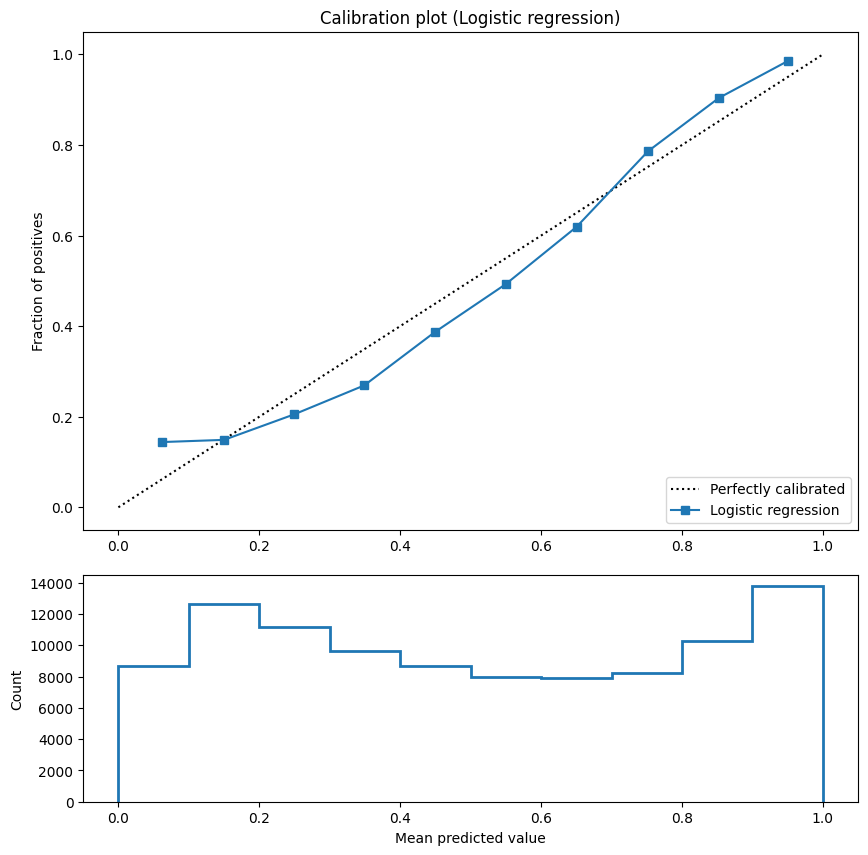

In [ ]:
# plot calibration curve for logistic regression
plot_calibration_curve("Logistic regression", 1, probs_lgr)

It seems pretty decent. We do the same for the SVM.

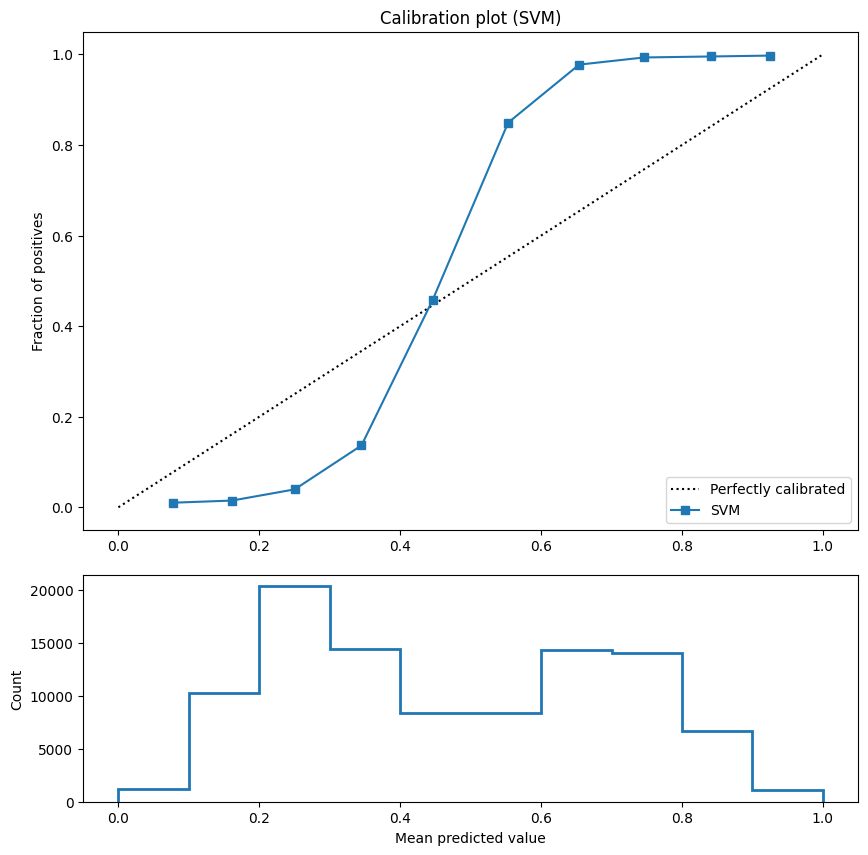

In [ ]:
# plot calibration curve for the SVM
plot_calibration_curve("SVM", 1, probs_svc)

It is evident that the SVM model is far from calibrated. We can say that is under-confident when it predicts that the sample does not belong to the positive class and overconfident otherwise. So, how can we fix this?

# Calibrating the model
The two most popular methods of calibrating a machine learning model are the `isotonic` and `Platt's` method.

`Scikit-learn` provides a base estimator for calibrating models through the `CalibratedClassifierCV` class. For this example, we will use the Platt's method, which is equivalent to setting the `method` argument in the constructor of the class to `sigmoid`. If you want to use the isotonic method you can pass that instead.

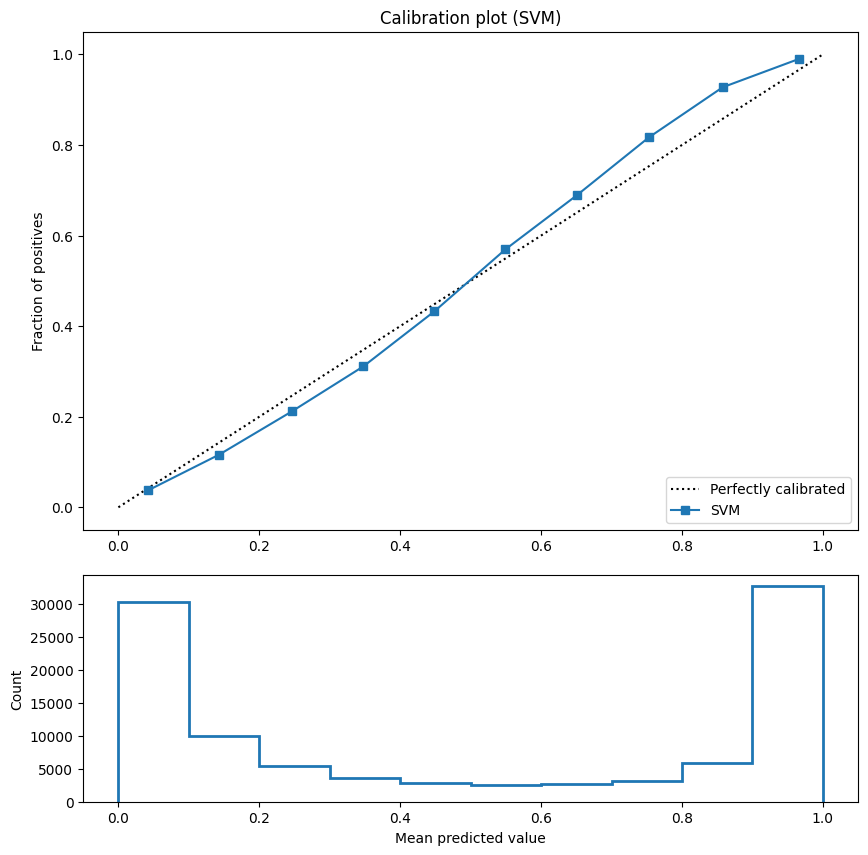

In [ ]:
from sklearn.calibration import CalibratedClassifierCV


lgr = LogisticRegression(C=1, solver='lbfgs')
svc = SVC(max_iter=10000, probability=True)

platts_scaling = CalibratedClassifierCV(svc, cv=2, method='sigmoid')
platts_scaling.fit(X_train, y_train)
calibrated_probs = platts_scaling.predict_proba(X_test)[:,1]

plot_calibration_curve("SVM", 3, calibrated_probs)

The outcome for the SVM classifier is impressively different. Now we have a calibrated SVM classifier. Please note that if you call the `predict_proba` method on the SVM classifier, the results are already calibrated via `Platt's` method.

Also, keep in mind that the accuracy of the model might be lower after calibration. For example, the AUC-ROC curve is now 0.963. Thus, we can see that in some case we might have a trade-off between accuracy and calibration to consider. You can always check other metrics as well (e.g. precision, recall, F1 score etc.).


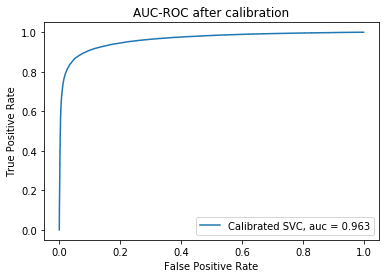

# Conclusion
In this, we examined what is model calibration, why and when to use it, how to check if your classifier is calibrated and how to potentially fix it if not.

Finally, I want to give a rule of thumb, as to whether to use isotonic regression of Platt’s scaling. Isotonic regression does not make the sigmoid assumption, thus, it may be a better fit for a broad amount of cases. On the other hand, it is more prone to overfit. Thus, if we have a small data set, Platt’s scaling might work better.

# Comparison of Calibration of Classifiers

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=2, random_state=42
)

train_samples = 100  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples,
)

In [ ]:
import numpy as np

from sklearn.svm import LinearSVC


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [ ]:
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0)
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py

<ipython-input-17-4f44fa19d80a>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")


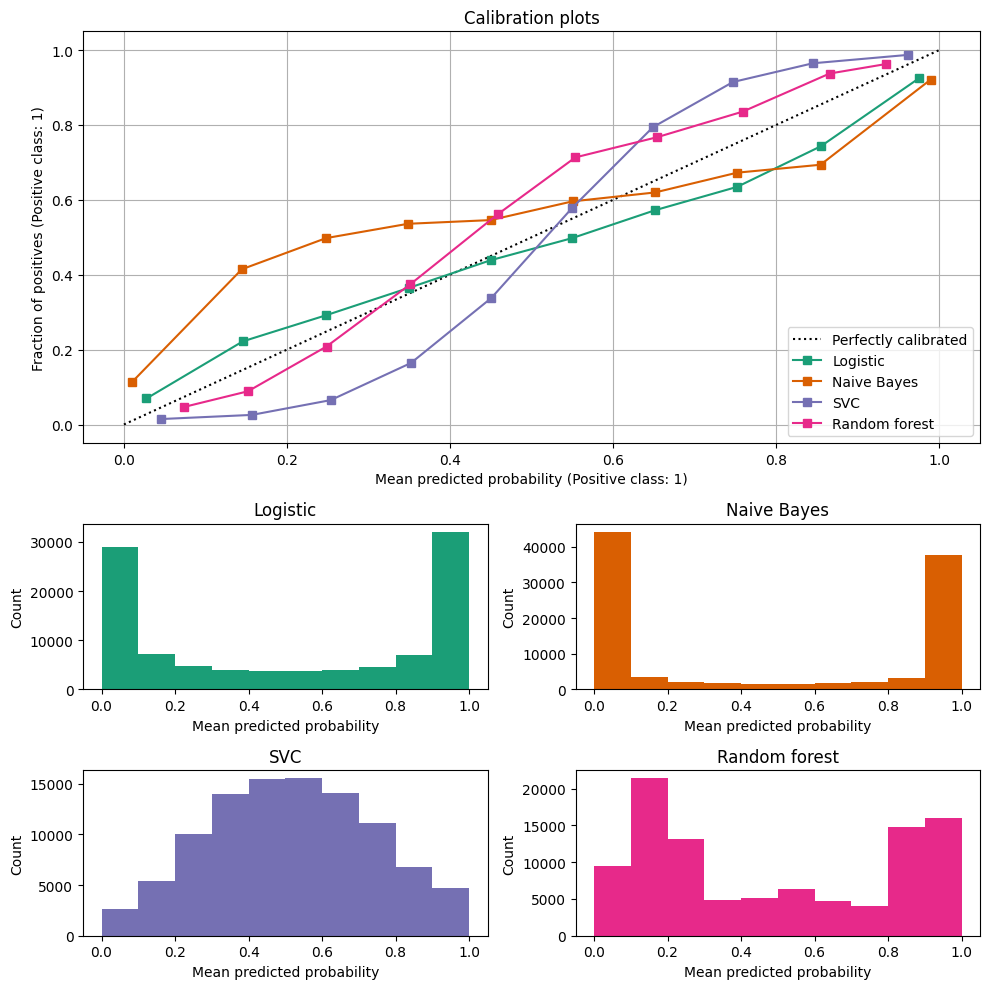

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()


# Probability Calibration curves
+ https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=10, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.99, random_state=42
)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
]

<ipython-input-20-99b4c233152d>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")


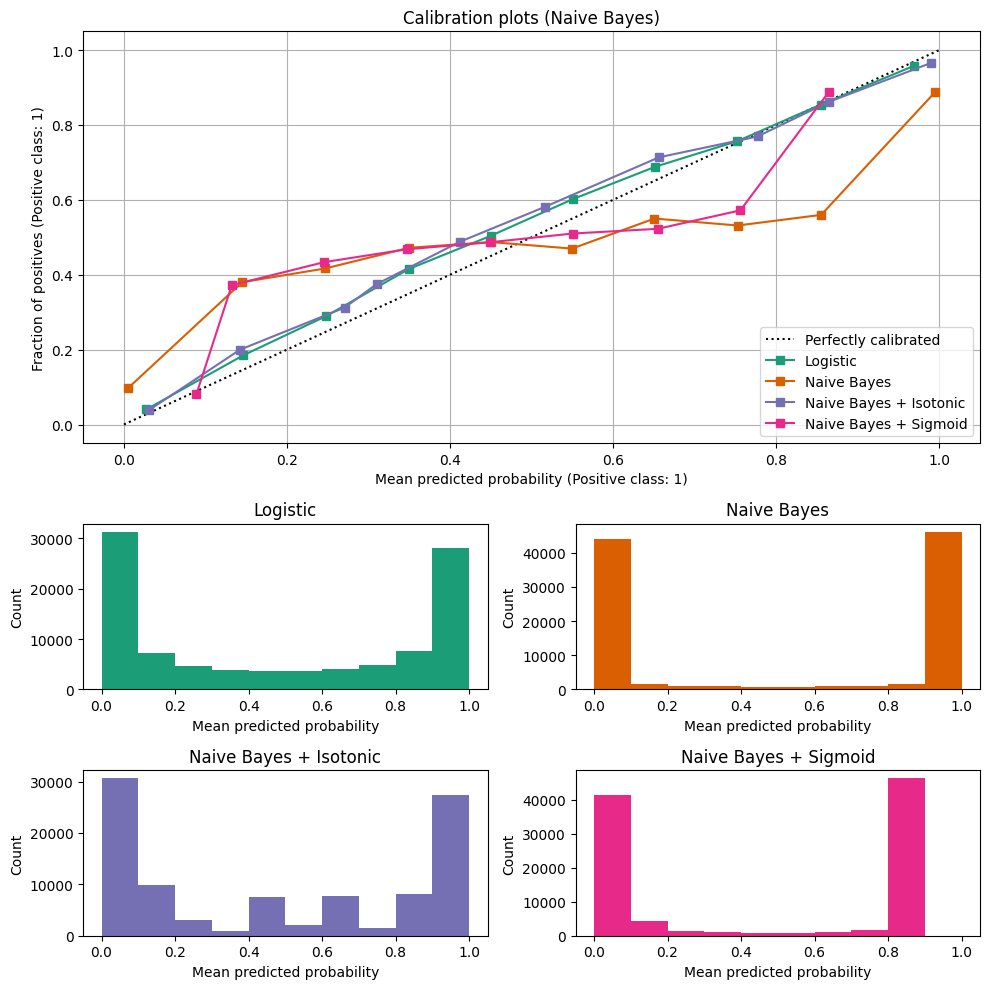

In [ ]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

Uncalibrated GaussianNB is poorly calibrated because of the redundant features which violate the assumption of feature-independence and result in an overly confident classifier, which is indicated by the typical transposed-sigmoid curve. Calibration of the probabilities of GaussianNB with Isotonic regression can fix this issue as can be seen from the nearly diagonal calibration curve. :ref:sigmoid regression <sigmoid_regressor> also improves calibration slightly, albeit not as strongly as the non-parametric isotonic regression. This can be attributed to the fact that we have plenty of calibration data such that the greater flexibility of the non-parametric model can be exploited.

In [ ]:
from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
    log_loss,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Precision,Recall,F1,Roc auc
Classifier,,,,,,
Logistic,0.098921,0.323178,0.872009,0.851408,0.861586,0.863157
Naive Bayes,0.117608,0.782755,0.857400,0.875941,0.866571,0.865055
Naive Bayes + Isotonic,0.098332,0.370738,0.883065,0.836224,0.859007,0.862690
Naive Bayes + Sigmoid,0.108880,0.368896,0.861106,0.871277,0.866161,0.865300


In [ ]:
import numpy as np

from sklearn.svm import LinearSVC


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output for binary classification."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0, 1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba


lr = LogisticRegression(C=1.0)
svc = NaivelyCalibratedLinearSVC(max_iter=10_000)
svc_isotonic = CalibratedClassifierCV(svc, cv=2, method="isotonic")
svc_sigmoid = CalibratedClassifierCV(svc, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (svc, "SVC"),
    (svc_isotonic, "SVC + Isotonic"),
    (svc_sigmoid, "SVC + Sigmoid"),
]

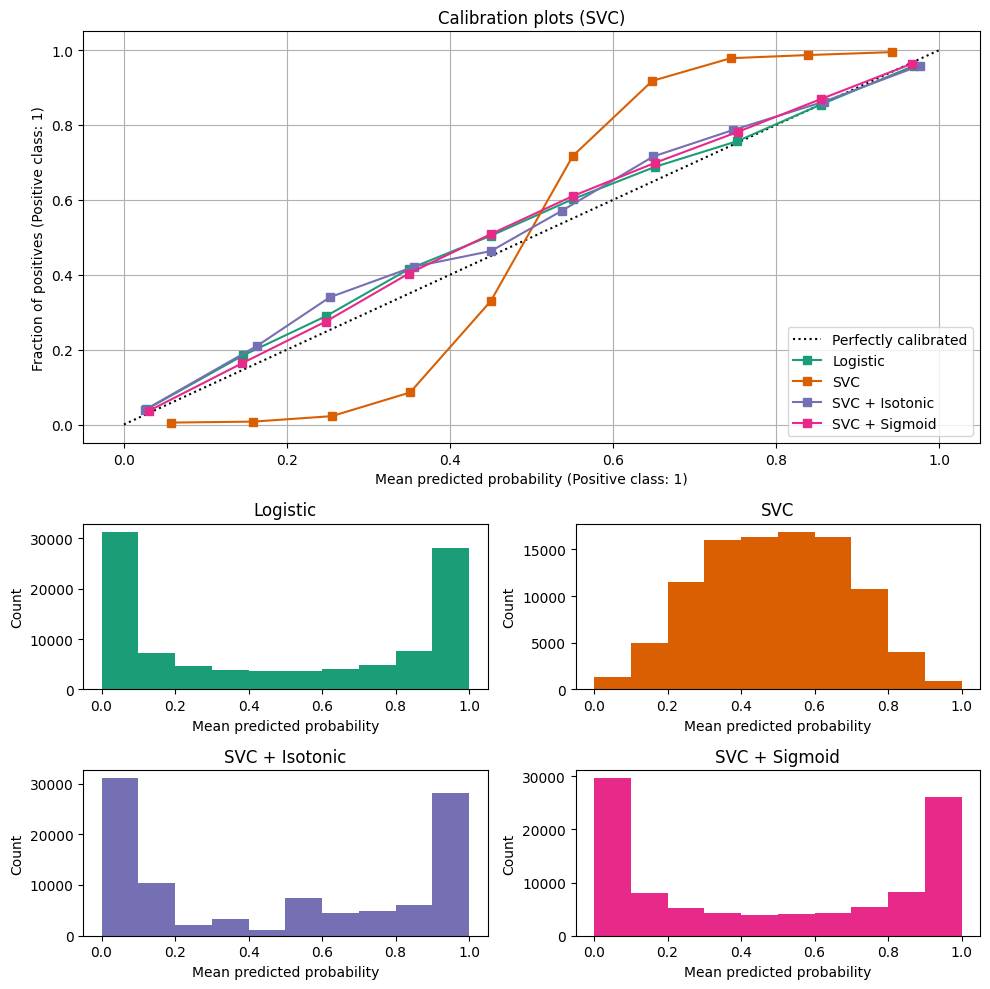

In [ ]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (SVC)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()


LinearSVC shows the opposite behavior to GaussianNB; the calibration curve has a sigmoid shape, which is typical for an under-confident classifier. In the case of LinearSVC, this is caused by the margin property of the hinge loss, which focuses on samples that are close to the decision boundary (support vectors). Samples that are far away from the decision boundary do not impact the hinge loss. It thus makes sense that LinearSVC does not try to separate samples in the high confidence region regions. This leads to flatter calibration curves near 0 and 1 and is empirically shown with a variety of datasets in Niculescu-Mizil & Caruana 1.

Both kinds of calibration (sigmoid and isotonic) can fix this issue and yield similar results.

In [ ]:
scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df


,Brier loss,Log loss,Precision,Recall,F1,Roc auc
Classifier,,,,,,
Logistic,0.098921,0.323178,0.872009,0.851408,0.861586,0.863157
SVC,0.144944,0.465663,0.872201,0.851772,0.861865,0.863420
SVC + Isotonic,0.099827,0.377027,0.853032,0.878041,0.865356,0.863306
SVC + Sigmoid,0.098760,0.321306,0.873706,0.848743,0.861044,0.862967
